In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import cv2
import imageio
import datetime

sys.path.append('../deepcell')

import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras import Input, Model, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Softmax

# from scipy.stats import mode

from skimage.measure import regionprops, regionprops_table

from sklearn import metrics as sk_metrics

In [3]:
from deepcell.losses import weighted_categorical_crossentropy

from deepcell.mibi_data_help import create_cell_tf_dataset
from deepcell.graph_utils import get_max_cells

from deepcell.tmp_func_holder import get_marker_dict
from deepcell.tmp_func_holder import load_mibi_data, load_celltypes

In [4]:
%%time

# data_path = 'D:/GNN/data/TNBC'
data_path = '../data/TNBC/'

mibi_data_path = os.path.join(data_path, 'TNBCShareData')
mibi_label_path = os.path.join(data_path, 'TNBC_labels/label_images.npy')
mibi_celltype_path = os.path.join(data_path, 'TNBCcellTypes')
TNBCpanelInfo_path = os.path.join(data_path,'TNBCpanelInfo.csv')

# print(mibi_data_path)

POINT_LIST = [2, 5, 8, 9, 21, 22, 24, 26, 34, 37, 38, 41]

mibi_data = load_mibi_data(mibi_data_path, point_list=POINT_LIST)
mibi_labels = np.load(mibi_label_path)
mibi_celltypes = load_celltypes(mibi_celltype_path, point_list=POINT_LIST)

# cell type label codes
"""
  % 0 - background ; 1- Negative ; 2- Endothel ; 3- Mesenchyme ;
  % 4- Tumor ; 5- Immune: Tregs ; 6- Immune: CD4 T ; 7- Immune CD8 T ; 8-
  % Immune CD3 T ; 9- Immune: NK ; 10- Immune: B ; 11- Immune:
  % Neutrophiles ; 12- Immune: Macrophages ; 13- Immune: DC ; 14- Immune:
  % DC/Mono ; 15- Immune: Mono/Neu ; 16: Immune: Other

"""

## created a dictionary of cell types 
celltype_label_dict = {0:'background', 1:'Negative', 2:'Endothel', 3:'Mesenchyme',
                       4:'Tumor', 5:'Tregs', 6:'CD4 T', 7:'CD8 T', 8:'CD3 T',
                       9:'Nk', 10:'B', 11:'Neutrophiles', 12:'Macrophages',
                       13:'DC', 14: 'DC_Mono', 15:'Mono_Neu', 16:'Other'}


# get good channels that were used in original clustering
TNBCpanelInfo = pd.read_csv(TNBCpanelInfo_path)
good_markers = TNBCpanelInfo[TNBCpanelInfo['Used for clustering'] == 1]['Label'].to_list()
marker_dict = get_marker_dict(os.path.join(mibi_data_path,'Point1'))#, index=True)
marker_idxs = list(map(marker_dict.get, good_markers))

# num of features = # of good markers
num_features = len(good_markers)

# create a look up table to go from index to maker name
marker_idx_dict = dict(zip(list(range(len(good_markers))),good_markers))

# Shrink raw data and labelsa to line up with cell type image
tmp_mibi_data = mibi_data[:,30:-30, 30:-30, marker_idxs]
mibi_labels = mibi_labels[:,30:-30, 30:-30, :]
mibi_celltypes = mibi_celltypes[:,30:-30, 30:-30, :]

CPU times: user 44.1 s, sys: 3.87 s, total: 48 s
Wall time: 48 s


## Cell Table

In [4]:
%%time

from deepcell.mibi_data_help import data_split

training_data, validation_data = data_split(tmp_mibi_data,
                                            mibi_labels,
                                            mibi_celltypes,
                                            marker_idx_dict,
                                            train_val_cutoff=.85,
                                            normalize=True)

mibi_data_train, mibi_labels_train, mibi_celltypes_train = training_data
mibi_data_val, mibi_labels_val, mibi_celltypes_val = validation_data

CPU times: user 3min 17s, sys: 2.19 s, total: 3min 19s
Wall time: 3min 19s


In [5]:
%%time 

from deepcell.tmp_func_holder import get_cell_df

cell_df_train = get_cell_df(mibi_data_train, mibi_labels_train, mibi_celltypes_train, good_markers, marker_idx_dict)
cell_df_val = get_cell_df(mibi_data_val, mibi_labels_val, mibi_celltypes_val, good_markers, marker_idx_dict)

CPU times: user 1min 45s, sys: 90.8 ms, total: 1min 45s
Wall time: 1min 45s


In [6]:
from deepcell.mibi_data_help import cells_dataset_from_df

train_dataset, train_df, val_dataset, val_df = cells_dataset_from_df(cell_df_train, cell_df_val)

In [7]:
BATCH_SIZE = 100

train = train_dataset.shuffle(train_df.shape[0]).batch(BATCH_SIZE)
val  = val_dataset.shuffle(val_df.shape[0]).batch(BATCH_SIZE)


#get class names from val data
true_label_data = np.concatenate([y['celltypes'] for x, y in val])
# true_label_data = true_label_data.reshape(true_label_data.shape[0]*true_label_data.shape[1], -1)
true_label = np.argmax(true_label_data, axis=1)
class_names = list(map(celltype_label_dict.__getitem__, set(true_label)))

In [8]:
def dense_model():
    inputs = Input(shape=(23), name='feature_matrix')
    x = inputs
    for i in range(1):
        x = Dense(128, activation='relu')(x)
#         x = BatchNormalization(axis=-1)(x)
#         x = Activation('relu')(x)
    x = Dense(17)(x)
    x = Softmax(axis=-1, name='celltypes')(x)
    return Model(inputs=inputs, outputs=x)

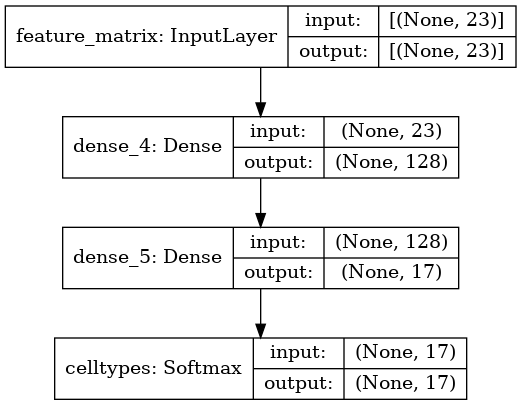

In [11]:
model = dense_model()
plot_model(model, show_shapes=True)#, to_file='logs/model.png')

In [12]:
optimizer = Adam(learning_rate=1e-3)
# losses = {'celltypes': tf.keras.losses.CategoricalCrossentropy()}
losses = {'celltypes': weighted_categorical_crossentropy}
metrics = {'celltypes': ['accuracy', 'Precision', 'Recall']}
model.compile(optimizer=optimizer, loss=losses, metrics=metrics)

model_type = "cells_only_FC"
log_dir = "logs/"+ model_type

# define basic TensorBoard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(train,
          epochs= 64,
          batch_size= BATCH_SIZE,
          validation_data= val,
          callbacks= [tensorboard_callback])

Epoch 1/64
304/304 [==============================] - 4s 8ms/step - loss: 6.7770 - accuracy: 0.6343 - precision: 0.7737 - recall: 0.1160 - val_loss: 4.0358 - val_accuracy: 0.7682 - val_precision: 0.9314 - val_recall: 0.5726
Epoch 2/64
304/304 [==============================] - 2s 5ms/step - loss: 3.4671 - accuracy: 0.7593 - precision: 0.9364 - recall: 0.5729 - val_loss: 3.4792 - val_accuracy: 0.7736 - val_precision: 0.8938 - val_recall: 0.6604
Epoch 3/64
304/304 [==============================] - 2s 6ms/step - loss: 2.9509 - accuracy: 0.7644 - precision: 0.8860 - recall: 0.6544 - val_loss: 3.2589 - val_accuracy: 0.7790 - val_precision: 0.8729 - val_recall: 0.6967
Epoch 4/64
304/304 [==============================] - 2s 6ms/step - loss: 2.8069 - accuracy: 0.7687 - precision: 0.8659 - recall: 0.6823 - val_loss: 3.2656 - val_accuracy: 0.7769 - val_precision: 0.8667 - val_recall: 0.6998
Epoch 5/64
304/304 [==============================] - 2s 6ms/step - loss: 2.6397 - accuracy: 0.7770 - pr

In [13]:
%load_ext tensorboard
%tensorboard --logdir logs --bind_all

In [14]:
predictions = np.array([])
labels =  np.array([])
for x, y in val:
    predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis=-1)])
    labels = np.concatenate([labels, np.argmax(y['celltypes'].numpy(), axis=-1)])

# Calculate the confusion matrix
#     cm = sk_metrics.confusion_matrix(true_label, test_pred)
cm = sk_metrics.confusion_matrix(labels, predictions, normalize='true')

In [15]:
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
        cm (array, shape = [n, n]): a confusion matrix of integer classes
        class_names (array, shape = [n]): String names of the integer classes
    """
    
    figure = plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=90)
    plt.yticks(tick_marks, class_names)
    
    # Compute the labels form the normalized confusion matrix
    labels = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    
    # Use white text if squres are dark; otherwise black
    threshold = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = 'white' if cm[i,j] > threshold else 'black'
        plt.text(j, i, labels[i, j], horizontalalignment='center', color=color)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    return figure

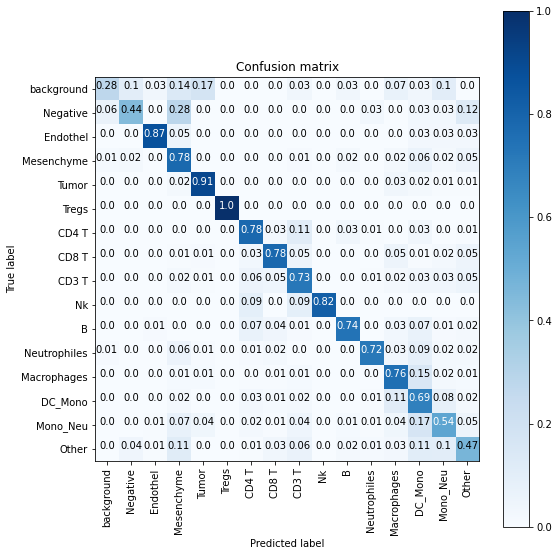

In [16]:
fig = plot_confusion_matrix(cm, class_names)

## Small image patches NO adj

In [5]:
%%time

from deepcell.mibi_data_help import create_cell_tf_dataset

train_dataset, val_dataset = create_cell_tf_dataset(tmp_mibi_data, 
                                                    mibi_labels, 
                                                    mibi_celltypes, 
                                                    marker_idx_dict,
                                                    mode = 'FC',
                                                    reshape=True)

Reshaped feature data from (10, 1988, 1988, 1) to (160, 512, 512, 1)
Reshaped training data from (10, 1988, 1988, 23) to (160, 512, 512, 23)
Reshaped feature data from (10, 1988, 1988, 1) to (160, 512, 512, 1)
Reshaped training data from (10, 1988, 1988, 1) to (160, 512, 512, 1)
Reshaped feature data from (2, 1988, 1988, 1) to (32, 512, 512, 1)
Reshaped training data from (2, 1988, 1988, 23) to (32, 512, 512, 23)
Reshaped feature data from (2, 1988, 1988, 1) to (32, 512, 512, 1)
Reshaped training data from (2, 1988, 1988, 1) to (32, 512, 512, 1)
CPU times: user 6min 47s, sys: 23.9 s, total: 7min 10s
Wall time: 6min 38s


In [18]:
BATCH_SIZE = 10

train = train_dataset.shuffle(len(train_dataset)).batch(BATCH_SIZE)
val = val_dataset.shuffle(len(val_dataset)).batch(BATCH_SIZE)

#get class names from val data
true_label_data = np.concatenate([y['celltypes'] for x, y in val])
true_label_data = true_label_data.reshape(true_label_data.shape[0]*true_label_data.shape[1], -1)
true_label = np.argmax(true_label_data, axis=1)
class_names = list(map(celltype_label_dict.__getitem__, set(true_label)))

In [19]:
def dense_model():
    inputs = Input(shape=(None, num_features), name='feature_matrix')
    x = inputs
    for i in range(1):
#         x = Dense(128, activation='relu')(x)
        x = Dense(128)(x)
#         x = BatchNormalization(axis=-1)(x)
        x = Activation('relu')(x)
    x = Dense(17)(x)
    x = Softmax(axis=-1, name='celltypes')(x)
    return Model(inputs=inputs, outputs=x)

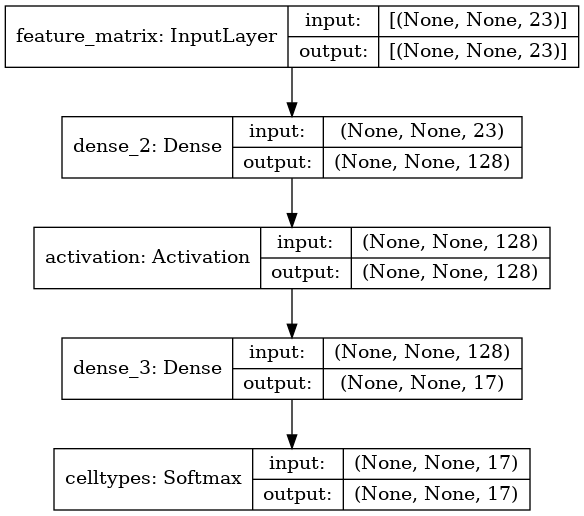

In [20]:
model = dense_model()
plot_model(model, show_shapes=True, to_file='logs/model.png')

In [21]:
optimizer = Adam(learning_rate=1e-3)
# losses = {'celltypes': tf.keras.losses.CategoricalCrossentropy()}
losses = {'celltypes': weighted_categorical_crossentropy}
metrics = {'celltypes': ['accuracy', 'Precision', 'Recall']}
model.compile(optimizer=optimizer, loss=losses, metrics=metrics)

model_type = "small_patches_FC"
log_dir = "logs/"+ model_type 

# define basic TensorBoard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(train,
          epochs= 64,
          batch_size= BATCH_SIZE,
          validation_data= val,
          callbacks= [tensorboard_callback])

Epoch 1/64
16/16 [==============================] - 2s 80ms/step - loss: 14.6367 - accuracy: 0.1492 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 13.2526 - val_accuracy: 0.3667 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/64
16/16 [==============================] - 0s 8ms/step - loss: 13.7925 - accuracy: 0.4049 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 12.5295 - val_accuracy: 0.7234 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/64
16/16 [==============================] - 0s 9ms/step - loss: 13.3875 - accuracy: 0.8388 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 12.0415 - val_accuracy: 0.7599 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/64
16/16 [==============================] - 0s 9ms/step - loss: 12.4444 - accuracy: 0.6290 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 11.1765 - val_accuracy: 0.5598 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/64
16/16 [=====================

In [22]:
%load_ext tensorboard
%tensorboard --logdir logs --bind_all

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 335), started 0:09:07 ago. (Use '!kill 335' to kill it.)

## Small Image Patches Autoencoder + Celltype Prediction

In [23]:
train_dataset, val_dataset = create_cell_tf_dataset(tmp_mibi_data, 
                                                    mibi_labels, 
                                                    mibi_celltypes, 
                                                    marker_idx_dict,
                                                    mode='AE_FC',
                                                    reshape=True)

Reshaped feature data from (10, 1988, 1988, 1) to (160, 512, 512, 1)
Reshaped training data from (10, 1988, 1988, 23) to (160, 512, 512, 23)
Reshaped feature data from (10, 1988, 1988, 1) to (160, 512, 512, 1)
Reshaped training data from (10, 1988, 1988, 1) to (160, 512, 512, 1)
Reshaped feature data from (2, 1988, 1988, 1) to (32, 512, 512, 1)
Reshaped training data from (2, 1988, 1988, 23) to (32, 512, 512, 23)
Reshaped feature data from (2, 1988, 1988, 1) to (32, 512, 512, 1)
Reshaped training data from (2, 1988, 1988, 1) to (32, 512, 512, 1)


In [24]:
BATCH_SIZE = 10

train = train_dataset.shuffle(len(train_dataset)).batch(BATCH_SIZE)
val = val_dataset.shuffle(len(val_dataset)).batch(BATCH_SIZE)

#get class names from val data
true_label_data = np.concatenate([y['celltypes'] for x, y in val])
true_label_data = true_label_data.reshape(true_label_data.shape[0]*true_label_data.shape[1], -1)
true_label = np.argmax(true_label_data, axis=1)
class_names = list(map(celltype_label_dict.__getitem__, set(true_label)))

In [25]:
def autoencoder_celltype():
    inputs = Input(shape=(None, num_features), name='feature_matrix')
    x = inputs
    
    for i in range(1):
        x = Dense(128, activation='relu')(x)
        x = Dense(8, activation='relu', name='encoded')(x)
         
    decoder = Dense(num_features, activation='sigmoid', name='decoded')(x)
    
    celltype = Dense(17, activation='sigmoid', name='celltypes')(x)
    return Model(inputs=inputs, outputs=[decoder, celltype])   

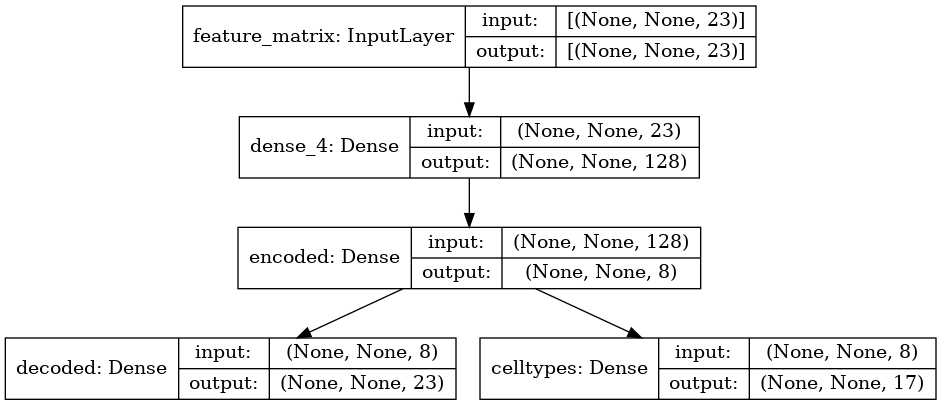

In [26]:
model = autoencoder_celltype()
plot_model(model, show_shapes=True, to_file='logs/model.png')

In [27]:
optimizer = Adam(learning_rate=1e-3)
# losses = {'celltypes': tf.keras.losses.CategoricalCrossentropy()}
losses = {'decoded': tf.keras.losses.MeanSquaredError(),
          'celltypes': weighted_categorical_crossentropy}
metrics = {'celltypes': ['accuracy', 'Precision', 'Recall']}
model.compile(optimizer=optimizer, loss=losses, metrics=metrics)

model_type = "small_patches_AC_FC"
log_dir = "logs/"+ model_type 

# define basic TensorBoard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(train,
          epochs= 64,
          batch_size= BATCH_SIZE,
          validation_data= val,
          callbacks= [tensorboard_callback])

Epoch 1/64
16/16 [==============================] - 3s 92ms/step - loss: 14.5854 - decoded_loss: 0.2302 - celltypes_loss: 14.3553 - celltypes_accuracy: 0.0856 - celltypes_precision: 0.0639 - celltypes_recall: 0.6076 - val_loss: 13.4998 - val_decoded_loss: 0.2082 - val_celltypes_loss: 13.2916 - val_celltypes_accuracy: 0.0455 - val_celltypes_precision: 0.0917 - val_celltypes_recall: 0.8443
Epoch 2/64
16/16 [==============================] - 0s 10ms/step - loss: 14.6878 - decoded_loss: 0.2234 - celltypes_loss: 14.4644 - celltypes_accuracy: 0.0176 - celltypes_precision: 0.0915 - celltypes_recall: 0.8685 - val_loss: 13.2508 - val_decoded_loss: 0.2006 - val_celltypes_loss: 13.0503 - val_celltypes_accuracy: 0.0558 - val_celltypes_precision: 0.1038 - val_celltypes_recall: 0.8714
Epoch 3/64
16/16 [==============================] - 0s 10ms/step - loss: 14.2277 - decoded_loss: 0.2159 - celltypes_loss: 14.0118 - celltypes_accuracy: 0.0188 - celltypes_precision: 0.0725 - celltypes_recall: 0.5981 - 

In [28]:
%load_ext tensorboard
%tensorboard --logdir logs --bind_all

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 335), started 0:16:00 ago. (Use '!kill 335' to kill it.)

## Full Image

In [29]:
train_dataset, val_dataset = create_cell_tf_dataset(tmp_mibi_data, 
                                                    mibi_labels, 
                                                    mibi_celltypes, 
                                                    marker_idx_dict,
                                                    mode = 'FC',
                                                    reshape=False)

In [30]:
BATCH_SIZE = 1

train = train_dataset.shuffle(len(train_dataset)).batch(BATCH_SIZE)
val = val_dataset.shuffle(len(val_dataset)).batch(BATCH_SIZE)

#get class names from val data
true_label_data = np.concatenate([y['celltypes'] for x, y in val])
true_label_data = true_label_data.reshape(true_label_data.shape[0]*true_label_data.shape[1], -1)
true_label = np.argmax(true_label_data, axis=1)
class_names = list(map(celltype_label_dict.__getitem__, set(true_label)))

In [31]:
def dense_model():
    inputs = Input(shape=(None, num_features), name='feature_matrix')
    x = inputs
    for i in range(1):
#         x = Dense(128, activation='relu')(x)
        x = Dense(128)(x)
#         x = BatchNormalization(axis=-1)(x)
        x = Activation('relu')(x)
    x = Dense(17)(x)
    x = Softmax(axis=-1, name='celltypes')(x)
    return Model(inputs=inputs, outputs=x)

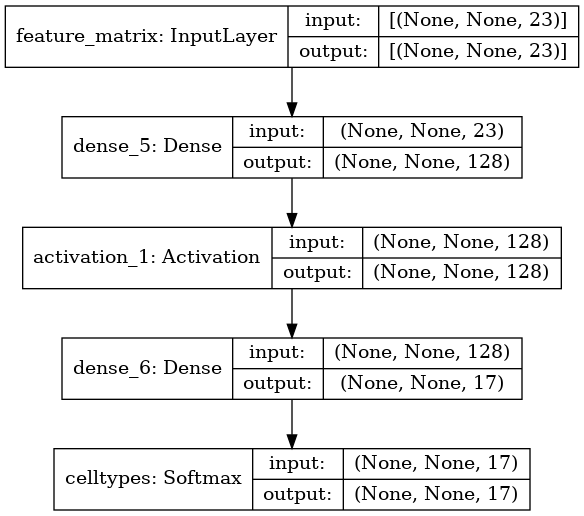

In [32]:
model = dense_model()
plot_model(model, show_shapes=True, to_file='logs/model.png')

In [33]:
optimizer = Adam(learning_rate=1e-3)
# losses = {'celltypes': tf.keras.losses.CategoricalCrossentropy()}
losses = {'celltypes': weighted_categorical_crossentropy}
metrics = {'celltypes': ['accuracy', 'Precision', 'Recall']}
model.compile(optimizer=optimizer, loss=losses, metrics=metrics)

model_type = "full_img_FC"
log_dir = "logs/"+ model_type 

# define basic TensorBoard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(train,
          epochs= 64,
          batch_size= BATCH_SIZE,
          validation_data= val,
          callbacks= [tensorboard_callback])

Epoch 1/64
10/10 [==============================] - 2s 135ms/step - loss: 12.1156 - accuracy: 0.2758 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 12.9031 - val_accuracy: 0.4178 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/64
10/10 [==============================] - 0s 10ms/step - loss: 11.8563 - accuracy: 0.2714 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 12.5532 - val_accuracy: 0.4936 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/64
10/10 [==============================] - 0s 10ms/step - loss: 10.4442 - accuracy: 0.5219 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 12.2269 - val_accuracy: 0.5822 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/64
10/10 [==============================] - 0s 10ms/step - loss: 11.9615 - accuracy: 0.5883 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 11.8798 - val_accuracy: 0.6183 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/64
10/10 [=================

In [34]:
%load_ext tensorboard
%tensorboard --logdir logs --bind_all

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 335), started 0:20:58 ago. (Use '!kill 335' to kill it.)

## Small Patch - Graph

In [35]:
train_dataset, val_dataset = create_cell_tf_dataset(tmp_mibi_data, 
                                                    mibi_labels, 
                                                    mibi_celltypes, 
                                                    marker_idx_dict,
                                                    mode = 'GCN',
                                                    reshape=True)

Reshaped feature data from (10, 1988, 1988, 1) to (160, 512, 512, 1)
Reshaped training data from (10, 1988, 1988, 23) to (160, 512, 512, 23)
Reshaped feature data from (10, 1988, 1988, 1) to (160, 512, 512, 1)
Reshaped training data from (10, 1988, 1988, 1) to (160, 512, 512, 1)
Reshaped feature data from (2, 1988, 1988, 1) to (32, 512, 512, 1)
Reshaped training data from (2, 1988, 1988, 23) to (32, 512, 512, 23)
Reshaped feature data from (2, 1988, 1988, 1) to (32, 512, 512, 1)
Reshaped training data from (2, 1988, 1988, 1) to (32, 512, 512, 1)


In [36]:
BATCH_SIZE = 10

train = train_dataset.shuffle(len(train_dataset)).batch(BATCH_SIZE)
val = val_dataset.shuffle(len(val_dataset)).batch(BATCH_SIZE)

#get class names from val data
true_label_data = np.concatenate([y['celltypes'] for x, y in val])
true_label_data = true_label_data.reshape(true_label_data.shape[0]*true_label_data.shape[1], -1)
true_label = np.argmax(true_label_data, axis=1)
class_names = list(map(celltype_label_dict.__getitem__, set(true_label)))

In [37]:
from spektral.layers import GraphConv

def graphconv_model(feature_shape=(None,num_features),
                    adj_shape=(None,None)):
    x_in = Input(shape=feature_shape, name='feature_matrix')
    a_in = Input(shape=adj_shape, name='adjacency_matrix')
    
    x = x_in
    for i in range(2):
        x = GraphConv(128)([x, a_in])
        x = BatchNormalization(axis=-1)(x)
        x = Activation('relu')(x)
    x = Dense(17)(x)
    x = Softmax(axis=-1, name='celltypes')(x)
    return Model(inputs=[x_in, a_in], outputs=x)

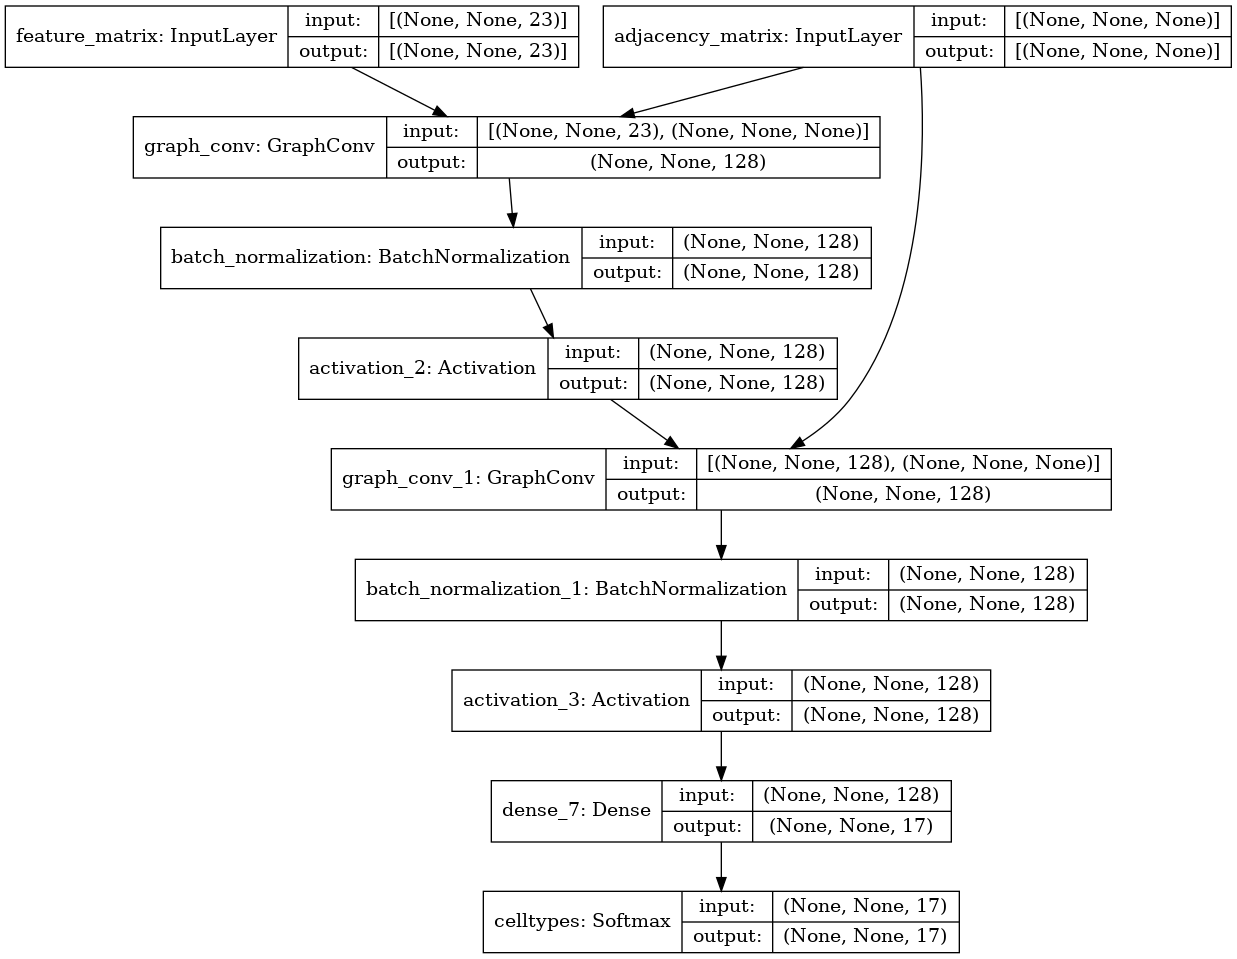

In [38]:
model = graphconv_model()
plot_model(model, show_shapes=True, to_file='logs/model.png')

In [39]:
optimizer = Adam(learning_rate=1e-3)
# losses = {'celltypes': tf.keras.losses.CategoricalCrossentropy()}
losses = {'celltypes': weighted_categorical_crossentropy}
metrics = {'celltypes': ['accuracy', 'Precision', 'Recall']}
model.compile(optimizer=optimizer, loss=losses, metrics=metrics)

model_type = "small_path_graph"
log_dir = "logs/"+ model_type 

# define basic TensorBoard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(train,
          epochs= 64,
          batch_size= BATCH_SIZE,
          validation_data= val,
          callbacks= [tensorboard_callback])

Epoch 1/64
16/16 [==============================] - 3s 105ms/step - loss: 15.9754 - accuracy: 0.1677 - precision: 0.1445 - recall: 0.0039 - val_loss: 13.4094 - val_accuracy: 0.6207 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/64
16/16 [==============================] - 0s 16ms/step - loss: 11.0484 - accuracy: 0.7157 - precision: 0.9503 - recall: 0.1592 - val_loss: 13.0693 - val_accuracy: 0.5378 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/64
16/16 [==============================] - 0s 16ms/step - loss: 9.3663 - accuracy: 0.7486 - precision: 0.9728 - recall: 0.6231 - val_loss: 13.0929 - val_accuracy: 0.3597 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/64
16/16 [==============================] - 0s 16ms/step - loss: 8.5755 - accuracy: 0.7355 - precision: 0.9274 - recall: 0.6164 - val_loss: 12.8805 - val_accuracy: 0.2613 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/64
16/16 [==============================] - 0s 16ms/step - lo

In [40]:
%load_ext tensorboard
%tensorboard --logdir logs --bind_all

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 335), started 0:28:04 ago. (Use '!kill 335' to kill it.)

## Full Img - Graph

In [41]:
train_dataset, val_dataset = create_cell_tf_dataset(tmp_mibi_data, 
                                                    mibi_labels, 
                                                    mibi_celltypes, 
                                                    marker_idx_dict,
                                                    mode = 'GCN',
                                                    reshape=False)

In [42]:
BATCH_SIZE = 1

train = train_dataset.shuffle(len(train_dataset)).batch(BATCH_SIZE)
val = val_dataset.shuffle(len(val_dataset)).batch(BATCH_SIZE)

#get class names from val data
true_label_data = np.concatenate([y['celltypes'] for x, y in val])
true_label_data = true_label_data.reshape(true_label_data.shape[0]*true_label_data.shape[1], -1)
true_label = np.argmax(true_label_data, axis=1)
class_names = list(map(celltype_label_dict.__getitem__, set(true_label)))

In [43]:
def graphconv_model(feature_shape=(None,num_features),
                    adj_shape=(None,None)):
    x_in = Input(shape=feature_shape, name='feature_matrix')
    a_in = Input(shape=adj_shape, name='adjacency_matrix')
    
    x = x_in
    for i in range(2):
        x = GraphConv(128)([x, a_in])
        x = BatchNormalization(axis=-1)(x)
        x = Activation('relu')(x)
    x = Dense(17)(x)
    x = Softmax(axis=-1, name='celltypes')(x)
    return Model(inputs=[x_in, a_in], outputs=x)

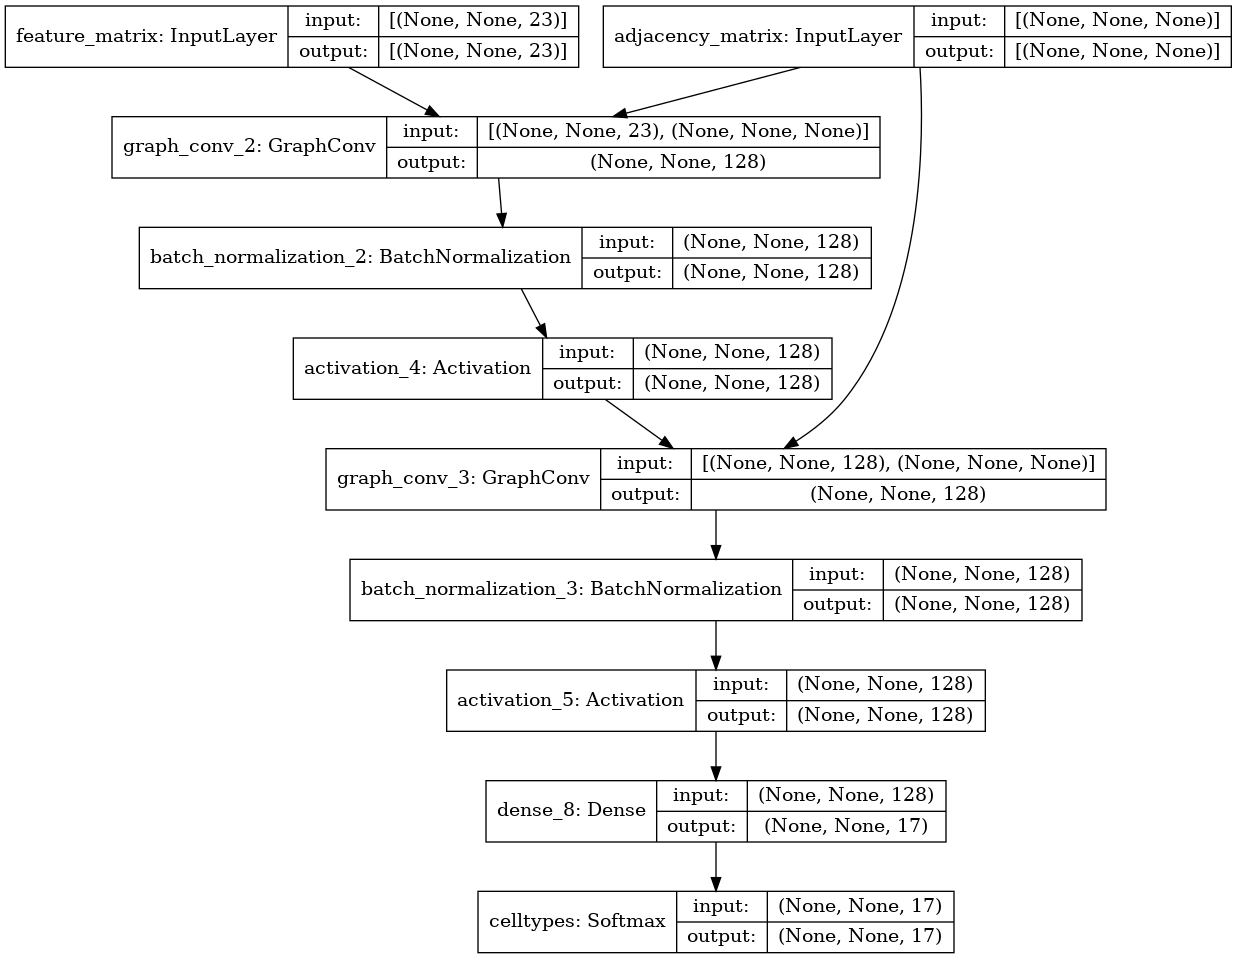

In [44]:
model = graphconv_model()
plot_model(model, show_shapes=True, to_file='logs/model.png')

In [45]:
optimizer = Adam(learning_rate=1e-3)
# losses = {'celltypes': tf.keras.losses.CategoricalCrossentropy()}
losses = {'celltypes': weighted_categorical_crossentropy}
metrics = {'celltypes': ['accuracy', 'Precision', 'Recall']}
model.compile(optimizer=optimizer, loss=losses, metrics=metrics)

model_type = "full_img_graph"
log_dir = "logs/"+ model_type 

# define basic TensorBoard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(train,
          epochs= 64,
          batch_size= BATCH_SIZE,
          validation_data= val,
          callbacks= [tensorboard_callback])

Epoch 1/64
10/10 [==============================] - 5s 295ms/step - loss: 14.1263 - accuracy: 0.1507 - precision: 0.4418 - recall: 0.0145 - val_loss: 12.8739 - val_accuracy: 0.4694 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/64
10/10 [==============================] - 2s 147ms/step - loss: 9.4981 - accuracy: 0.5473 - precision: 0.8365 - recall: 0.0537 - val_loss: 12.7915 - val_accuracy: 0.5462 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/64
10/10 [==============================] - 2s 147ms/step - loss: 10.0053 - accuracy: 0.5618 - precision: 0.9279 - recall: 0.1638 - val_loss: 12.7125 - val_accuracy: 0.5246 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/64
10/10 [==============================] - 2s 146ms/step - loss: 8.1769 - accuracy: 0.6347 - precision: 0.9237 - recall: 0.2433 - val_loss: 12.6489 - val_accuracy: 0.4655 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/64
10/10 [==============================] - 2s 147ms/step 

In [46]:
%load_ext tensorboard
%tensorboard --logdir logs --bind_all

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 335), started 0:35:58 ago. (Use '!kill 335' to kill it.)